# Классификация изображений

In [ ]:
!nvidia-smi

Sat Oct 31 07:08:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls ./drive/My\ Drive/Python\ data/

 A2_practice.zip
 Autoru
 best_model_en_640_1.hdf5
 best_model_en_640_2.hdf5
 data
 data.csv
 model_en_640_1.hdf5
 model_en_640_2.hdf5
 SF_Car_Classif_models
 sf-dl-car-classification.zip
 submission_en_512.csv
 submission_en_512_tta.csv
'[Гр18_Павел_Нагорный] фидбек студенту DST Max Olenin.gdoc'


In [ ]:
!mkdir -p ./kaggle/input ./kaggle/working/car

In [ ]:
!cp ./drive/My\ Drive/Python\ data/sf-dl-car-classification.zip ./kaggle/input/

**Импортируем модули**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choice
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (ModelCheckpoint, Callback, 
                                        EarlyStopping, ReduceLROnPlateau, 
                                        LearningRateScheduler)

from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("./kaggle/input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.csv', 'test.zip', 'sf-dl-car-classification.zip', 'train.zip', 'sample-submission.csv']
Python       : 3.6.9 (default, Oct  8 2020, 12:12:24) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [ ]:
!pip freeze > requirements.txt

## Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 640 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = './kaggle/input/'
PATH = "./kaggle/working/car/" # рабочая директория
SAVE_PATH = './kaggle/working/'

In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

## EDA / Анализ данных

In [ ]:
with zipfile.ZipFile('./kaggle/input/sf-dl-car-classification.zip', "r") as z:
    z.extractall('./kaggle/input/')

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.sample(7)

,Id,Category
99,111114.jpg,0
8450,157246.jpg,5
2882,222821.jpg,1
2177,156050.jpg,1
12856,137541.jpg,8
1358,267157.jpg,0
3877,140880.jpg,2


In [ ]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [ ]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Пример картинок (random sample)


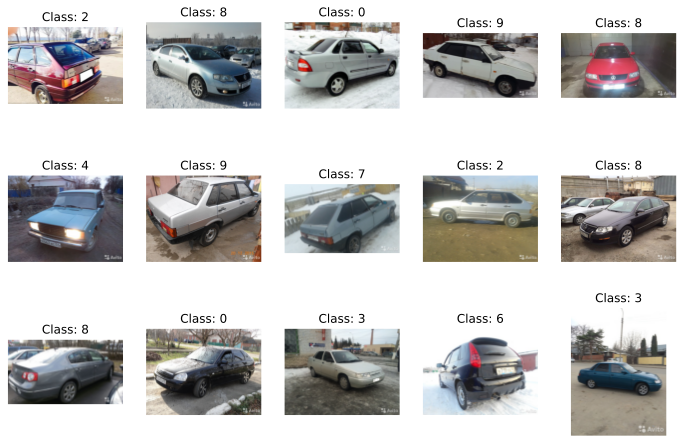

In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=15)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,5, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

./kaggle/working/car/train/4/
269929.jpg


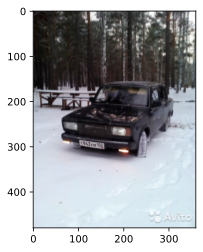

(360, 480)

In [ ]:
random_im_list = PATH+'train/'+str(np.random.randint(10))+'/'
random_im = choice(os.listdir(random_im_list))

print(random_im_list)
print(random_im)
image = PIL.Image.open(random_im_list+random_im)
imgplot = plt.imshow(image)
plt.show()
image.size

In [ ]:
# Оцениваем размеры картинок
sizes = {'width': [], 'height': []}
for cls in range(10):
    folder = PATH+'train/'+str(cls)+'/'
    for im_path in os.listdir(folder):
        im = PIL.Image.open(folder+im_path)
        sizes['width'].append(im.size[0])
        sizes['height'].append(im.size[1])    

In [ ]:
print(f'Max width size = { max(sizes["width"]) }')
print(f'Mean width size = {np.array(sizes["width"]).mean() }')
print(f'Min width size = {min(sizes["width"])}')
print()
print(f'Max height size = {max(sizes["height"])}')
print(f'Mean height size = {np.array(sizes["height"]).mean() }')
print(f'Min height size = {min(sizes["height"])}')

Max width size = 640
Mean width size = 607.4116059379218
Min width size = 130

Max height size = 480
Mean height size = 445.08598419124735
Min height size = 97


In [ ]:
# Словарь с некорректными картинками в обучающей выборке - эти изображения удаляем из набора
bad_imgs = {'0': 
        ['23675.jpg',
          '106274.jpg',
          '108635.jpg',
          '111745.jpg',
          '118468.jpg',
          '170545.jpg',
          '184454.jpg',
          '214149.jpg',
          '242897.jpg',
          '260934.jpg',
          '283917.jpg',
          '289476.jpg',
          '291089.jpg'], 
        '1': 
          ['2175.jpg',
          '19615.jpg',
          '100255.jpg',
          '106364.jpg',
          '111955.jpg',
          '118004.jpg',
          '161397.jpg',
          '162799.jpg',
          '171717.jpg',
          '190704.jpg',
          '211992.jpg',
          '213653.jpg',
          '234776.jpg'], 
        '2': 
         ['21819.jpg',
          '149921.jpg',
          '162828.jpg',
          '271465.jpg',
          '292641.jpg'],
        '3': 
         ['12080.jpg',
         '19672.jpg',
         '19817.jpg',
         '103321.jpg',
         '121693.jpg',
         '122947.jpg',
         '135372.jpg',
         '141052.jpg',
         '147457.jpg',
         '151120.jpg',
         '152125.jpg',
         '186470.jpg',
         '247500.jpg',
         '274933.jpg'], 
        '4': 
        ['271739.jpg',
         '251322.jpg',
         '250923.jpg',
         '236077.jpg',
         '202547.jpg',
         '188072.jpg',
         '176702.jpg',
         '174231.jpg',
         '167534.jpg',
         '151652.jpg',
         '135843.jpg',
         '115799.jpg',
         '107922.jpg',
         '100968.jpg',
         '1620.jpg'],
        '5': 
        ['267513.jpg',
        '262518.jpg',
        '258686.jpg',
        '245175.jpg',
        '198229.jpg',
        '188543.jpg',
        '128234.jpg',
        '110732.jpg',
        '110600.jpg',
        '107173.jpg',
        '104396.jpg'], 
        '6': 
        ['292194.jpg',
        '252178.jpg',
        '247036.jpg',
        '240371.jpg',
        '228602.jpg',
        '203539.jpg',
        '193236.jpg',
        '179955.jpg',
        '172352.jpg',
        '167237.jpg',
        '167164.jpg',
        '161554.jpg',
        '118807.jpg'],
        '7': 
        ['293583.jpg',
        '282883.jpg',
        '266264.jpg',
        '261307.jpg',
        '236117.jpg',
        '217770.jpg',
        '174354.jpg',
        '167998.jpg',
        '158661.jpg',
        '151413.jpg',
        '134291.jpg',
        '119163.jpg',
        '105028.jpg',
        '27822.jpg',
        '23236.jpg',
        '15333.jpg',
        '11823.jpg',
        '1078.jpg'], 
        '8': 
        ['243925.jpg',
        '213717.jpg',
        '169782.jpg',
        '162667.jpg',
        '156199.jpg',
        '145131.jpg',
        '138860.jpg',
        '138653.jpg',
        '138449.jpg',
        '136440.jpg',
        '134798.jpg',
        '27474.jpg',
        '19908.jpg',
        '12728.jpg',
        '126.jpg'], 
        '9': 
        ['284695.jpg',
        '271782.jpg',
        '252387.jpg',
        '227052.jpg',
        '226153.jpg',
        '194102.jpg',
        '182170.jpg',
        '172626.jpg',
        '156805.jpg',
        '133425.jpg',
        '132848.jpg',
        '132782.jpg',
        '119611.jpg',
        '28750.jpg',
        '24470.jpg',
        '21816.jpg',
        '21804.jpg',
        '20112.jpg']
        }

In [ ]:
i = 0
for fld in bad_imgs.keys():
  directory = './kaggle/working/car/train/'+ fld + '/'
  for img in bad_imgs[fld]:
    os.remove(directory+img)
    # print(f'removed image {img}')
    i += 1
print(i)

135


# Строим модель на EfficientNet

In [ ]:
!pip install -U efficientnet

     |████████████████████████████████| 51kB 5.1MB/s 


In [ ]:
import efficientnet.tfkeras as efn

In [ ]:
base_model = efn.EfficientNetB6(
    weights='imagenet', # Подгружаем веса imagenet
    include_top=False,  # Выходной слой (голову) будем менять т.к. у нас други классы
    input_shape=input_shape)

165527552/165527152 [==============================] - 5s 0us/step


In [ ]:
base_model.trainable = False

### Обучаем новую "голову"

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

# SGD(lr=LR*10, momentum=0.85)

In [ ]:
checkpoint = ModelCheckpoint(SAVE_PATH+'best_model_en_640_1.hdf5', 
                             monitor = ['val_accuracy'] , 
                             verbose = 1  , 
                             mode = 'max')

callbacks_list = [checkpoint]

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 13116 images belonging to 10 classes.
Found 2310 images belonging to 10 classes.


In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS, # пробуем на большем количестве эпох
        callbacks = callbacks_list)

Epoch 1/10
1640/1640 [==============================] - ETA: 0s - loss: 1.4840 - accuracy: 0.4790
Epoch 00001: saving model to ./kaggle/working/best_model_en_640_1.hdf5
1640/1640 [==============================] - 1436s 876ms/step - loss: 1.4840 - accuracy: 0.4790 - val_loss: 0.7055 - val_accuracy: 0.7515
Epoch 2/10
1640/1640 [==============================] - ETA: 0s - loss: 1.0574 - accuracy: 0.6271
Epoch 00002: saving model to ./kaggle/working/best_model_en_640_1.hdf5
1640/1640 [==============================] - 1463s 892ms/step - loss: 1.0574 - accuracy: 0.6271 - val_loss: 0.5664 - val_accuracy: 0.8069
Epoch 3/10
1640/1640 [==============================] - ETA: 0s - loss: 0.9413 - accuracy: 0.6600
Epoch 00003: saving model to ./kaggle/working/best_model_en_640_1.hdf5
1640/1640 [==============================] - 1456s 888ms/step - loss: 0.9413 - accuracy: 0.6600 - val_loss: 0.4970 - val_accuracy: 0.8234
Epoch 4/10
1640/1640 [==============================] - ETA: 0s - loss: 0.8440 

size 224 accuracy - Accuracy: 73.47%

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

289/289 [==============================] - 195s 675ms/step - loss: 0.3271 - accuracy: 0.8844
Accuracy: 88.44%


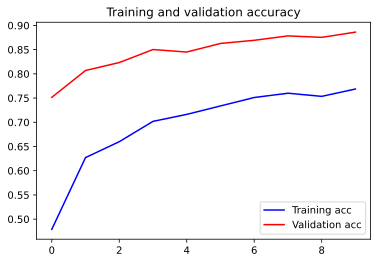

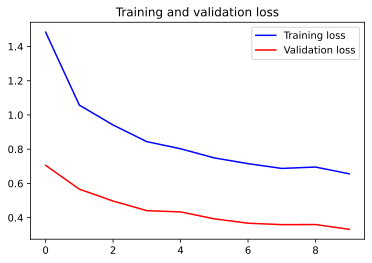

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save(SAVE_PATH+'model_en_640_1.hdf5')
model.load_weights(SAVE_PATH+'best_model_en_640_1.hdf5')

In [ ]:
!cp ./kaggle/working/model_en_640_1.hdf5 ./drive/My\ Drive/Python\ data/
!cp ./kaggle/working/best_model_en_640_1.hdf5 ./drive/My\ Drive/Python\ data/

cp: cannot stat './kaggle/working/model_en_640_1.hdf5': No such file or directory
cp: cannot stat './kaggle/working/best_model_en_640_1.hdf5': No such file or directory


# Размораживаем верхние 4+ блоки сети

In [ ]:
!cp ./drive/My\ Drive/Python\ data/model_en_640_1.hdf5 ./kaggle/working/
!cp ./drive/My\ Drive/Python\ data/best_model_en_640_1.hdf5 ./kaggle/working/

cp: cannot stat './drive/My Drive/Python data/model_en_640_1.hdf5': No such file or directory
cp: cannot stat './drive/My Drive/Python data/best_model_en_640_1.hdf5': No such file or directory


In [ ]:
FixedDropout = Dropout(0.25)
model = load_model(SAVE_PATH+'model_en_640_1.hdf5', custom_objects={'FixedDropout': FixedDropout})
model.load_weights(SAVE_PATH+'best_model_en_640_1.hdf5')

NameError: ignored

In [ ]:
BATCH_SIZE=4

In [ ]:
set_trainable = False
i = 0
for layer in model.layers:
    if 'block4' in layer.name:
        set_trainable = True
    layer.trainable = set_trainable
    i += int(set_trainable)

In [ ]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
len(model.trainable_variables)/len(model.variables)

In [ ]:
checkpoint = ModelCheckpoint(SAVE_PATH+'best_model_en_640_2.hdf5', 
                             monitor = ['val_accuracy'] , 
                             verbose = 1  , 
                             mode = 'max')

callbacks_list = [checkpoint]

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS, # пробуем на большем количестве эпох
        callbacks = callbacks_list)

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save(SAVE_PATH+'model_en_640_2.hdf5')
model.load_weights(SAVE_PATH+'best_model_en_640_2.hdf5')

In [ ]:
!cp ./kaggle/working/model_en_640_2.hdf5 ./drive/My\ Drive/Python\ data/
!cp ./kaggle/working/best_model_en_640_2.hdf5 ./drive/My\ Drive/Python\ data/

# Размораживаем всю сеть

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 20  # эпох на обучение
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 512 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = './kaggle/input/'
PATH = "./kaggle/working/car/" # рабочая директория
SAVE_PATH = './kaggle/working/'

In [ ]:
!cp ./drive/My\ Drive/Python\ data/model_en_512_2.hdf5 ./kaggle/working/
!cp ./drive/My\ Drive/Python\ data/best_model_en_512_2.hdf5 ./kaggle/working/

In [ ]:
FixedDropout = Dropout(0.25)
model = load_model(SAVE_PATH+'model_en_512_2.hdf5', custom_objects={'FixedDropout': FixedDropout})
model.load_weights(SAVE_PATH+'best_model_en_512_2.hdf5')

In [ ]:
model.trainable = True

In [ ]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * 0.7

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
checkpoint = ModelCheckpoint(SAVE_PATH+'best_model_en_512_2_3.hdf5', 
                             monitor = ['val_accuracy'] , 
                             verbose = 1  , 
                             mode = 'max')

callbacks_list = [checkpoint, lr_scheduler]

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 13116 images belonging to 10 classes.
Found 2310 images belonging to 10 classes.


In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS, # пробуем на большем количестве эпох
        callbacks = callbacks_list)

Epoch 1/20
3279/3279 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9483
Epoch 00001: saving model to ./kaggle/working/best_model_en_512_2_3.hdf5
3279/3279 [==============================] - 1538s 469ms/step - loss: 0.1654 - accuracy: 0.9483 - val_loss: 0.0885 - val_accuracy: 0.9771
Epoch 2/20
3279/3279 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9571
Epoch 00002: saving model to ./kaggle/working/best_model_en_512_2_3.hdf5
3279/3279 [==============================] - 1530s 467ms/step - loss: 0.1355 - accuracy: 0.9571 - val_loss: 0.0924 - val_accuracy: 0.9766
Epoch 3/20
3279/3279 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.9620
Epoch 00003: saving model to ./kaggle/working/best_model_en_512_2_3.hdf5
3279/3279 [==============================] - 1536s 468ms/step - loss: 0.1248 - accuracy: 0.9620 - val_loss: 0.0947 - val_accuracy: 0.9753
Epoch 4/20
3279/3279 [==============================] - ETA: 0s - loss: 0

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

578/578 [==============================] - 133s 230ms/step - loss: 0.1019 - accuracy: 0.9840
Accuracy: 98.40%


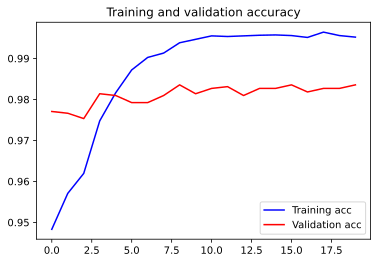

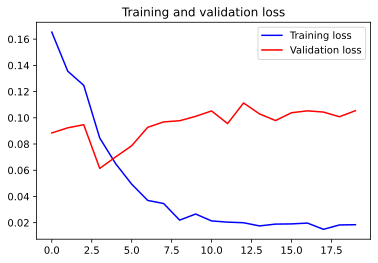

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save(SAVE_PATH+'model_en_512_2_3.hdf5')
model.load_weights(SAVE_PATH+'best_model_en_512_2_3.hdf5')

In [ ]:
!cp ./kaggle/working/best_model_en_512_2_3.hdf5 ./drive/My\ Drive/Python\ data/
!cp ./kaggle/working/model_en_512_2_3.hdf5 ./drive/My\ Drive/Python\ data/

# Предсказание на тестовых данных

In [ ]:
FixedDropout = Dropout(0.25)

In [ ]:
model = load_model(SAVE_PATH+'model_en_512_2_3.hdf5', custom_objects={'FixedDropout': FixedDropout})

In [ ]:
model.load_weights(SAVE_PATH+'best_model_en_512_2_3.hdf5')

In [ ]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [ ]:
test_sub_generator.samples

6675

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

Instructions for updating:
Please use Model.predict, which supports generators.
1669/1669 [==============================] - 104s 62ms/step


In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('./kaggle/submission_en_512_2.csv', index=False)
print('Save submit')

Save submit


In [ ]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,7


In [ ]:
!cp ./kaggle/submission_en_512_2.csv ./drive/My\ Drive/Python\ data/

# Test Time Augmentation


In [ ]:
FixedDropout = Dropout(0.25)

In [ ]:
model = load_model(SAVE_PATH+'model_en_512_2_3.hdf5', custom_objects={'FixedDropout': FixedDropout})

In [ ]:
model.load_weights(SAVE_PATH+'best_model_en_512_2_3.hdf5')

In [ ]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-9rkpv1gs
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-9rkpv1gs
     |████████████████████████████████| 49.5MB 70kB/s 
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-cp36-none-any.whl size=28165 sha256=5faffd018ee280a14d282c63ca5b871b4b94bd41bc33efcc6624ae62e246fe97
  Stored in directory: /tmp/pip-ephem-wheel-cache-tgqxcre5/wheels/d9/10/55/6fca35a4072f87d694876d56ece64db3846cf45e1da1c381fe
Successfully built ImageDataAugmentor
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [ ]:
AUGM = albumentations.Compose([
#     albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(p=0.5, limit=10, interpolation=1),
#     albumentations.RandomBrightnessContrast(p=0.5, brightness_limit=-0.3, contrast_limit=0.3),
#     albumentations.GaussianBlur(p=0.5),
#     albumentations.HueSaturationValue(p=0.5),
#     albumentations.CenterCrop(height=200, width=220),
#     albumentations.RGBShift(p=0.5),
#     albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    
    albumentations.RandomBrightnessContrast(p=0.5),    
    albumentations.RandomGamma(p=0.5),    
#     albumentations.CLAHE(p=0.5), 
#     albumentations.GaussNoise(var_limit=(100, 150), p=0.5),
#     albumentations.Blur(blur_limit=3, p=0.5),
#     albumentations.InvertImg(p=0.5),
    
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

In [ ]:
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGM,
    validation_split=VAL_SPLIT,
)

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [ ]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

1669/1669 [==============================] - 105s 63ms/step


In [ ]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('./kaggle/submission_en_512_2_tta.csv', index=False)
print('Save submit')

Save submit


In [ ]:
!cp ./kaggle/submission_en_512_2_tta.csv ./drive/My\ Drive/Python\ data/